In [1]:
%run "..\..\Startup_py3.py"
sys.path.append(r"..\..\..\..\Documents")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

# library design specific tools
from ImageAnalysis3.library_tools import LibraryDesigner as ld
from ImageAnalysis3.library_tools import LibraryTools as lt
# biopython imports
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.Blast.Applications import NcbiblastnCommandline
from Bio.Blast import NCBIXML

21112


In [2]:
## Some folders
# human genome
reference_folder = r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\Genomes\human\hg38'
genome_folder = os.path.join(reference_folder, 'Genome')
# Library directories
pool_folder = r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain'
if not os.path.exists(pool_folder):
    print(f"Create pool_folder: {pool_folder}")
    os.makedirs(pool_folder)
else:
    print(f"Use pool_folder: {pool_folder}")

Use pool_folder: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain


In [3]:
# folder for sub-pool
library_folder = os.path.join(pool_folder, f'human_brain_promoter_enhancer_v2')
if not os.path.exists(library_folder):
    print(f"create library folder: {library_folder}")
    os.makedirs(library_folder)
# folder for fasta sequences
sequence_folder = os.path.join(library_folder, 'sequences')
if not os.path.exists(sequence_folder):
    print(f"create sequence folder: {sequence_folder}")
    os.makedirs(sequence_folder)
# folder to save result probes
report_folder = os.path.join(library_folder, 'reports')
if not os.path.exists(report_folder):
    print(f"create report folder: {report_folder}")
    os.makedirs(report_folder)
    
print(f"-- library_folder: {library_folder}")
print(f"-- sequence_folder: {sequence_folder}")
print(f"-- report_folder: {report_folder}")

-- library_folder: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2
-- sequence_folder: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences
-- report_folder: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\reports


In [4]:
import pandas as pd
save_folder = os.path.join(library_folder, 'Summary_tables')

if not os.path.exists(save_folder):
    print(f"Create save_folder: {save_folder}")
    os.makedirs(save_folder)
else:
    print(f"Use save_folder: {save_folder}")

Create save_folder: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\Summary_tables


In [5]:
# laod encoding
# summarize total readout usage
encoding_folder = os.path.join(library_folder, f'Encoding_design')
print(encoding_folder)
region_2_bits = pickle.load(open(os.path.join(encoding_folder, 'region_2_bits.pkl'), 'rb'))

\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\Encoding_design


In [6]:
# load probes
probes = []
final_pb_filename = os.path.join(library_folder, 'blast_full_probes.fasta')

with open(final_pb_filename, 'r') as handle:
    for record in SeqIO.parse(handle, "fasta"):
        probes.append(record)

In [7]:
# load region names and real coordinates
region_2_names = {}
region_2_coords = {}
for _pb in probes:
    _reg = _pb.id.split('loc_')[1].split('_')[0]
    _start, _end = _reg.split(':')[1].split('-')
    # gene info
    _gene = _pb.id.split('gene_')[1].split('_')[0]
    _pb_pos = int(_pb.id.split('pos_')[1].split('_')[0]) + int(_start)
    
    if _gene not in region_2_names:
        region_2_names[_gene] = _reg
    if _gene not in region_2_coords:
        region_2_coords[_gene] = [_pb_pos]
    else:
        region_2_coords[_gene].append(_pb_pos)
print(region_2_names)

{'ABCA8': '17:68942892-68967892', 'ABCA8-enhancer-374': '17:68783840-68805152', 'ABCG2': '4:88219128-88244128', 'ACSBG1': '15:78233188-78258188', 'ACSS1': '20:25046480-25071480', 'ACSS1-enhancer-410': '20:24984883-25015742', 'ACSS1-enhancer-411': '20:25126438-25146937', 'ACSS1-enhancer-412': '20:25245305-25265804', 'ACSS1-enhancer-413': '20:25286723-25307222', 'ACTA2': '10:88978839-89003839', 'ADAM28': '8:24281569-24306569', 'ADAM3A': '8:39510352-39535352', 'ADAMTS2': '5:179332961-179357961', 'ADAMTS4': '1:161186554-161211554', 'ADCY4': '14:24322593-24347593', 'ADGRF5': '6:46942443-46967443', 'ADRA1B': '5:159852580-159877580', 'AGT': '1:230733076-230758076', 'AGT-enhancer-27': '1:230338582-230359081', 'AGT-enhancer-28': '1:230900121-230920620', 'ALK': '2:29909086-29934086', 'ALK-enhancer-31': '2:29603503-29624002', 'ALOX5AP': '13:30700978-30725978', 'ANK1': '8:41884262-41909262', 'ANK1-enhancer-233': '8:41596701-41617200', 'ANK1-enhancer-234': '8:41655630-41681691', 'ANK1-enhancer-235'

In [8]:
# generate dict
pb_len = 42
min_probe_num = 10

region_2_probeInfo = {}
for _gene in region_2_coords:
    _name = region_2_names[_gene]
    _chr = _name.split(':')[0]
    _coords = region_2_coords[_gene]
    if len(_coords) < min_probe_num:
        continue
    _info = f"{_chr}:{np.min(_coords)}-{np.max(_coords)+pb_len}"
    region_2_probeInfo[_gene] = _info

In [21]:
# laod encoding
# summarize total readout usage
region_2_readout_dict = pickle.load(open(os.path.join(library_folder, 'region_2_readout.pkl'), 'rb'))
print(region_2_readout_dict)
region_2_readout_dict = {
    _k.replace('_enhancer','-enhancer'):_v for _k,_v in region_2_readout_dict.items()
}

{'hSE-0': ['c45', 'c88', 'c89'], 'PRDM16': ['c34', 'c53', 'c56'], 'PRDM16_enhancer-0': ['c4', 'c16', 'c21'], 'PRDM16_enhancer-1': ['c46', 'c84', 'c87'], 'PRDM16_enhancer-2': ['c25', 'c95', 'c113'], 'PRDM16_enhancer-3': ['c36', 'c52', 'c57'], 'PRDM16_enhancer-4': ['c28', 'c62', 'c83'], 'hSE-1': ['c0', 'c37', 'c47'], 'hSE-2': ['c54', 'c78', 'c104'], 'hSE-3': ['c7', 'c55', 'c69'], 'hSE-4': ['c2', 'c17', 'c20'], 'hSE-5': ['c24', 'c80', 'c108'], 'hSE-6': ['c9', 'c41', 'c49'], 'hSE-7': ['c5', 'c60', 'c77'], 'SRARP': ['c35', 'c61', 'c76'], 'hSE-8': ['c40', 'c88', 'c111'], 'hSE-9': ['c1', 'c8', 'c12'], 'hSE-10': ['c48', 'c81', 'c106'], 'C1QC': ['c30', 'c97', 'c105'], 'C1QC_enhancer-5': ['c3', 'c71', 'c90'], 'hSE-11': ['c14', 'c29', 'c34'], 'ID3': ['c11', 'c63', 'c75'], 'hSE-13': ['c27', 'c92', 'c107'], 'CD52': ['c10', 'c53', 'c72'], 'hSE-14': ['c4', 'c85', 'c109'], 'PTPRU': ['c58', 'c77', 'c98'], 'hSE-15': ['c21', 'c96', 'c100'], 'PTPRU_enhancer-6': ['c31', 'c43', 'c44'], 'hSE-16': ['c42', 'c8

In [10]:
# load used readouts
readout_usage_file = os.path.join(library_folder, 'readout_usage.pkl')
readout_dict = pickle.load(open(readout_usage_file, 'rb'))

In [11]:
readout_dict

{'c': [SeqRecord(seq=Seq('CCCTAATCCCGACTTTGTGGGTACGTTGAT'), id='NDB_376', name='NDB_376', description='NDB_376', dbxrefs=[]),
  SeqRecord(seq=Seq('TGCCACATCTAGGCGATACATGAGAGGCGT'), id='NDB_578', name='NDB_578', description='NDB_578', dbxrefs=[]),
  SeqRecord(seq=Seq('GACGTATATTTGTTCGAATCCGCCTTCAAC'), id='NDB_456', name='NDB_456', description='NDB_456', dbxrefs=[]),
  SeqRecord(seq=Seq('AGCCAGCTCGTAGCGCCTGAATTAGCTATA'), id='NDB_400', name='NDB_400', description='NDB_400', dbxrefs=[]),
  SeqRecord(seq=Seq('TCCGTTAAACGTCGGCTGCGTACTGGTACA'), id='NDB_533', name='NDB_533', description='NDB_533', dbxrefs=[]),
  SeqRecord(seq=Seq('CGTCTATGCATCGTATTCGCCTTACTGTGT'), id='NDB_387', name='NDB_387', description='NDB_387', dbxrefs=[]),
  SeqRecord(seq=Seq('TCTCAAGGTTACCGGTTGTCTATATCGTCT'), id='NDB_568', name='NDB_568', description='NDB_568', dbxrefs=[]),
  SeqRecord(seq=Seq('AGAGAGCGACTTGGGAACGCCTTCATATCC'), id='NDB_464', name='NDB_464', description='NDB_464', dbxrefs=[]),
  SeqRecord(seq=Seq('CTAAAG

## bit_2_readout

In [61]:
dtype_dict = {_v:_k for _k,_v in ia.classes._allowed_kwds.items()}

for _dtype, _records in readout_dict.items():
    
    bit_readout_df = pd.DataFrame([[_i+1, _r.id] for _i, _r in enumerate(_records)], columns=['Bit','ReadoutName'])
    save_filename = os.path.join(save_folder, f'CTP14-human_gene-enhancer_{dtype_dict[_dtype]}_readouts.csv')
    print(save_filename)
    bit_readout_df.to_csv(save_filename, index=False)

\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\Summary_tables\CTP14-human_gene-enhancer_combo_readouts.csv


In [13]:
bit_readout_df

,Bit,ReadoutName
0,1,NDB_376
1,2,NDB_578
2,3,NDB_456
3,4,NDB_400
4,5,NDB_533
...,...,...
109,110,NDB_350
110,111,NDB_510
111,112,NDB_439
112,113,NDB_371


# Codebook

In [17]:
region_2_probeInfo.keys()

dict_keys(['ABCA8', 'ABCA8-enhancer-374', 'ABCG2', 'ACSBG1', 'ACSS1', 'ACSS1-enhancer-410', 'ACSS1-enhancer-411', 'ACSS1-enhancer-412', 'ACSS1-enhancer-413', 'ACTA2', 'ADAM28', 'ADAM3A', 'ADAMTS2', 'ADAMTS4', 'ADCY4', 'ADGRF5', 'ADRA1B', 'AGT', 'AGT-enhancer-27', 'AGT-enhancer-28', 'ALK', 'ALK-enhancer-31', 'ALOX5AP', 'ANK1', 'ANK1-enhancer-233', 'ANK1-enhancer-234', 'ANK1-enhancer-235', 'ANK1-enhancer-236', 'ANK1-enhancer-237', 'ANKFN1', 'ANO3', 'ANO4', 'APBB1IP', 'AQP4', 'AQP4-enhancer-381', 'AQP4-enhancer-382', 'AQP4-enhancer-383', 'AQP4-enhancer-384', 'AQP4-enhancer-385', 'ARL4C', 'ARPP19', 'ARPP21', 'ARPP21-enhancer-66', 'ARPP21-enhancer-67', 'ARX', 'ASIC4', 'ATP1B2', 'ATP2B1', 'ATP2B1-enhancer-325', 'B4GALNT2', 'B4GALNT3', 'B4GALNT3-enhancer-323', 'BARX2', 'BARX2-enhancer-319', 'BARX2-enhancer-320', 'BARX2-enhancer-321', 'BARX2-enhancer-322', 'BCAS1', 'BCL11B', 'BCL11B-enhancer-351', 'BDNF', 'BGN', 'BLNK', 'BLNK-enhancer-296', 'BMPR1B', 'BST2', 'BTBD11', 'BTBD11-enhancer-330', 'B

In [20]:
region_2_readout_dict

{'hSE-0': ['c45', 'c88', 'c89'],
 'PRDM16': ['c34', 'c53', 'c56'],
 'PRDM16_enhancer-0': ['c4', 'c16', 'c21'],
 'PRDM16_enhancer-1': ['c46', 'c84', 'c87'],
 'PRDM16_enhancer-2': ['c25', 'c95', 'c113'],
 'PRDM16_enhancer-3': ['c36', 'c52', 'c57'],
 'PRDM16_enhancer-4': ['c28', 'c62', 'c83'],
 'hSE-1': ['c0', 'c37', 'c47'],
 'hSE-2': ['c54', 'c78', 'c104'],
 'hSE-3': ['c7', 'c55', 'c69'],
 'hSE-4': ['c2', 'c17', 'c20'],
 'hSE-5': ['c24', 'c80', 'c108'],
 'hSE-6': ['c9', 'c41', 'c49'],
 'hSE-7': ['c5', 'c60', 'c77'],
 'SRARP': ['c35', 'c61', 'c76'],
 'hSE-8': ['c40', 'c88', 'c111'],
 'hSE-9': ['c1', 'c8', 'c12'],
 'hSE-10': ['c48', 'c81', 'c106'],
 'C1QC': ['c30', 'c97', 'c105'],
 'C1QC_enhancer-5': ['c3', 'c71', 'c90'],
 'hSE-11': ['c14', 'c29', 'c34'],
 'ID3': ['c11', 'c63', 'c75'],
 'hSE-13': ['c27', 'c92', 'c107'],
 'CD52': ['c10', 'c53', 'c72'],
 'hSE-14': ['c4', 'c85', 'c109'],
 'PTPRU': ['c58', 'c77', 'c98'],
 'hSE-15': ['c21', 'c96', 'c100'],
 'PTPRU_enhancer-6': ['c31', 'c43', 'c

In [19]:
codebook

,name,id,NDB_376,NDB_578,NDB_456,NDB_400,NDB_533,NDB_387,NDB_568,NDB_464,...,NDB_483,NDB_556,NDB_581,NDB_495,NDB_481,NDB_350,NDB_510,NDB_439,NDB_371,NDB_600
0,17:68946520-68964290,ABCA8,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,17:68785652-68803311,ABCA8-enhancer-374,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4:88219206-88244074,ABCG2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,15:78238903-78252484,ACSBG1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,20:25054732-25063307,ACSS1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1383,2:172687922-172722775,hSE-93,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1384,2:216018213-216032049,hSE-94,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1385,2:219274481-219286275,hSE-96,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1386,2:219662291-219674797,hSE-98,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
# generate the codebook
codebook = pd.DataFrame(columns=['name','id']+[_r.id for _r in readout_dict['c']])
# decide region ids first
codebook['id'] = list(region_2_probeInfo.keys())
# region names
codebook['name'] = [region_2_probeInfo[str(_gene)] for _gene in codebook['id']]
# code
max_bit = np.max([np.max([int(_b[1:]) for _b in _bits]) 
                  for _gname, _bits in region_2_readout_dict.items()]) + 1
for _gene in codebook['id']:
    _bits = region_2_readout_dict[_gene]
    binary_code = []
    for _i in range(max_bit):
        if f"c{_i}" in _bits:
            binary_code.append(1)
        else:
            binary_code.append(0)
    #print(_gene)
    codebook.loc[codebook['id']==_gene, codebook.columns[2:]] = binary_code
    #codebook.loc[codebook['name']==_gene,'id'] = int(_bits[0].split('u')[1])

In [23]:
codebook

,name,id,NDB_376,NDB_578,NDB_456,NDB_400,NDB_533,NDB_387,NDB_568,NDB_464,...,NDB_483,NDB_556,NDB_581,NDB_495,NDB_481,NDB_350,NDB_510,NDB_439,NDB_371,NDB_600
0,17:68946520-68964290,ABCA8,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,17:68785652-68803311,ABCA8-enhancer-374,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4:88219206-88244074,ABCG2,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,15:78238903-78252484,ACSBG1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,20:25054732-25063307,ACSS1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1383,2:172687922-172722775,hSE-93,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1384,2:216018213-216032049,hSE-94,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1385,2:219274481-219286275,hSE-96,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1386,2:219662291-219674797,hSE-98,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [24]:
# sanity check
codebook.values[:,2:].sum(1)

array([3, 3, 3, ..., 3, 3, 3], dtype=object)

In [25]:
from scipy.spatial.distance import pdist, squareform
dist_mat = squareform(pdist(codebook.values[:,2:].astype(np.int32)))**2

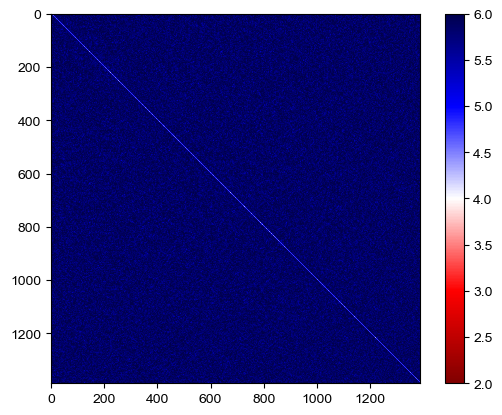

In [26]:
%matplotlib inline
fig, ax = plt.subplots()
_pf = ax.imshow(dist_mat, vmin=2, vmax=6, 
                cmap='seismic_r', interpolation=None)
plt.colorbar(_pf)
plt.show()

## append chromosome info

In [30]:
# add chromosome info
codebook['chr'] = [_n.split(':')[0] for _n in codebook['name']]
for _chr in np.unique(codebook['chr']):
    _chr_codebook = codebook.loc[codebook['chr']==_chr]
    _chr_reg_info = [np.mean([int(_loc) for _loc in _n.split(':')[1].split('-')]) for _n in _chr_codebook['name']]
    _chr_orders = np.array(_chr_reg_info).argsort().argsort().astype(np.int32)
    codebook.loc[codebook['chr']==_chr, 'chr_order'] = _chr_orders
# sort id
#codebook.sort_values('id', inplace=True)


In [31]:
codebook_save_filename = os.path.join(save_folder, 'CTP14-human_gene-enhancer_codebook_probe.csv')
if not os.path.exists(codebook_save_filename):
    print(codebook_save_filename)
    codebook.to_csv(codebook_save_filename,index=None)

\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\Summary_tables\CTP14-human_gene-enhancer_codebook_probe.csv


## Generate blanks

In [34]:
total_num

114

In [32]:
def convert_bits_to_matrix(bits):
    _matrix = np.ones([len(bits), np.max(bits)+1], dtype=np.int32) * -1
    for _i, _b in enumerate(bits):
        _matrix[_i, _b] = 1
    return _matrix

In [40]:
cand_encoding_file = os.path.join(encoding_folder, 
                                  f'encoding_bits_total-{total_num}_on-{on_num}.pkl',
                                  )
loaded_barcodes = pickle.load(open(cand_encoding_file, 'rb'))
print(len(loaded_barcodes))

# remove redundant barcodes
kept_barcodes = loaded_barcodes.copy()
kept_inds = np.zeros(len(kept_barcodes))
while np.sum(kept_inds) != len(kept_inds):
    kept_inds = np.ones(len(kept_barcodes), dtype=bool)
    _kept_mat = convert_bits_to_matrix(kept_barcodes)
    _dists = (total_num - (_kept_mat @ _kept_mat.T)) / 2
    _x, _y = np.where((_dists > 0) * (_dists <= 3))
    if len(_x) > 0:
        kept_inds[_x[0]] = False
        kept_barcodes = kept_barcodes[kept_inds]
        print(np.sum(kept_inds), kept_inds[_x[0]])
print(kept_barcodes.shape)

1875
(1875, 3)


In [42]:
used_barcodes = []
for _reg, _code in region_2_readout_dict.items():
    _barcode = np.array([int(_c.split('c')[1]) for _c in _code])
    used_barcodes.append(_barcode)
used_barcodes = np.array(used_barcodes)

free_barcodes = []
for _barcode in kept_barcodes:
    if (used_barcodes == _barcode).all(1).any():
        continue
    else:
        free_barcodes.append(_barcode)
print(len(free_barcodes))

487


## generate a randomly selected blank

In [51]:
num_blank = 99

num_bits = len(readout_dict['c'])

blank_bit_usage = np.zeros(num_bits)
exist_bit_usage = np.zeros(num_bits)
for _b in used_barcodes:
    exist_bit_usage[_b] += 1
# init 
sel_blank_barcodes = []
# shuffle free barcodes
#np.random.shuffle(free_barcodes)
cand_barcodes = [_b for _b in free_barcodes]
while len(sel_blank_barcodes) < num_blank:
    # for each cand bit, estimate bit usage
    _bit_usages = np.array([exist_bit_usage[_c].sum() + blank_bit_usage[_c].sum() for _c in cand_barcodes])
    #_blank_bit_usages = np.array([blank_bit_usage[_c].sum() for _c in cand_barcodes])
    # randomly select one of the smallest used bits
    _min_inds = np.where(_bit_usages == np.min(_bit_usages))[0]
    _sel_min_ind = _min_inds[np.random.randint(len(_min_inds),)]
    # append
    _sel_barcode = cand_barcodes[_sel_min_ind].copy()
    sel_blank_barcodes.append(_sel_barcode)
    # pop this candidate
    cand_barcodes.pop(_sel_min_ind)
    # update usage
    blank_bit_usage[_sel_barcode] += 1
    exist_bit_usage[_sel_barcode] += 1
# check
np.unique(blank_bit_usage, return_counts=True)

(array([0., 1., 2., 3.]), array([ 2,  3, 33, 76], dtype=int64))

In [52]:
blank_bit_usage

array([3., 3., 3., 2., 2., 3., 2., 3., 3., 3., 2., 3., 2., 2., 3., 2., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 2., 3., 3., 3., 3., 2., 2., 3., 3., 3., 3., 2., 2., 3.,
       3., 3., 2., 3., 2., 2., 3., 2., 3., 2., 3., 2., 2., 3., 3., 3., 3.,
       3., 2., 3., 3., 3., 3., 2., 2., 2., 3., 3., 3., 3., 3., 2., 2., 3.,
       2., 3., 3., 3., 3., 3., 2., 2., 3., 3., 3., 2., 3., 3., 3., 3., 3.,
       2., 3., 3., 3., 2., 2., 1., 2., 1., 1., 0., 0.])

## Save

In [53]:
print(save_folder)

\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\Summary_tables


In [54]:
save_filename = os.path.join(save_folder, 'blank_barcodes.npy')
print(save_filename)
if not os.path.exists(save_filename):
    np.save(save_filename, np.array(sel_blank_barcodes))

\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\Summary_tables\blank_barcodes.npy


In [56]:
# generate the codebook_blank
codebook_blank = pd.DataFrame(columns=['name','id']+[_r.id for _r in readout_dict['c']])
max_bit = np.max([np.max([int(_b[1:]) for _b in _bits]) 
                  for _gname, _bits in region_2_readout_dict.items()]) + 1
# decide region ids first
try:
    _id_start = np.max((codebook['id']).values.astype(np.int32))+1
except:
    _id_start = len(codebook)+1
codebook_blank['id'] = np.arange(_id_start, _id_start+len(sel_blank_barcodes))
# decide region names
codebook_blank['name'] = [f'B:{_i}-{_i+1}' for _i in range(len(sel_blank_barcodes))]
for _i, _name in enumerate(codebook_blank['name']):
    _barcode = sel_blank_barcodes[_i]
    binary_code = np.zeros(max_bit, dtype=np.int32)
    binary_code[_barcode] = 1
    codebook_blank.loc[codebook_blank['name']==_name, codebook_blank.columns[2:]] = binary_code
# add chromosome info
codebook_blank['chr'] = [_n.split(':')[0] for _n in codebook_blank['name']]
for _chr in np.unique(codebook_blank['chr']):
    _chr_codebook_blank = codebook_blank.loc[codebook_blank['chr']==_chr]
    _chr_reg_info = [np.mean([int(_loc) for _loc in _n.split(':')[1].split('-')]) for _n in _chr_codebook_blank['name']]
    _chr_orders = np.array(_chr_reg_info).argsort().argsort().astype(np.int32)
    codebook_blank.loc[codebook_blank['chr']==_chr, 'chr_order'] = _chr_orders

In [57]:
# Merge blank with codebook
codebook_w_blank = pd.concat([codebook,codebook_blank], ignore_index=True)
# sanity check
np.unique(codebook_w_blank.values[:,2:-2].astype(int).sum(1))

array([3])

In [58]:
codebook_w_blank

,name,id,NDB_376,NDB_578,NDB_456,NDB_400,NDB_533,NDB_387,NDB_568,NDB_464,...,NDB_581,NDB_495,NDB_481,NDB_350,NDB_510,NDB_439,NDB_371,NDB_600,chr,chr_order
0,17:68946520-68964290,ABCA8,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,17,33.0
1,17:68785652-68803311,ABCA8-enhancer-374,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,17,32.0
2,4:88219206-88244074,ABCG2,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,4,39.0
3,15:78238903-78252484,ACSBG1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,15,22.0
4,20:25054732-25063307,ACSS1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,20,18.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1482,B:94-95,1483,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,B,94.0
1483,B:95-96,1484,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,B,95.0
1484,B:96-97,1485,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,B,96.0
1485,B:97-98,1486,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,B,97.0


In [60]:
codebook_blank_save_filename = os.path.join(save_folder, 'CTP14-human_promoter-enhancer_codebook_probe_w_blank.csv')
if not os.path.exists(codebook_blank_save_filename):
    print(codebook_blank_save_filename)
    codebook_w_blank.to_csv(codebook_blank_save_filename,index=None)

\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\Summary_tables\CTP14-human_promoter-enhancer_codebook_probe_w_blank.csv
